In [1]:
from ds_loader import Dataset_Handler
from torchvision.models.mobilenet import mobilenet_v2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import torch.nn.functional as F

In [2]:
'''
Initialise some things
'''
class Config():
    batch_size = 32
    epochs = 20
    learn_rate = 0.0001
    CLASSES = 5
    generate = False
dsh = Dataset_Handler(dataset_folder='sleep_lab_data', target_hertz=50)

In [3]:
'''
Generate the data and store localy
'''
if Config.generate: dsh.generate_dataset()

In [4]:
'''
Load Data(numpy array) from disk)
'''
train_dl, test_dl = dsh.get_dataloader(hertz=50,modality="baseline.npy", batch_size=Config.batch_size)

{'WK': 1223, 'N1': 325, 'N2': 1871, 'N3': 1462, 'REM': 1158}
{'WK': 1223, 'N1': 1300, 'N2': 1871, 'N3': 1462, 'REM': 1158}


In [5]:
import net

# check for device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = net.SimpleNet()
model.to(device)

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=Config.learn_rate)
# define loss function
loss_function = nn.CrossEntropyLoss()

# check if model is on correct device
next(model.parameters()).is_cuda

False

'''
take fist network architecture
'''
# check for device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# define model
model = mobilenet_v2(pretrained=True)
model.features[0][0] = nn.Conv2d(11, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=Config.CLASSES)
model.to(device)

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=Config.learn_rate)
# define loss function
loss_function = nn.CrossEntropyLoss()

# check if model is on correct device
next(model.parameters()).is_cuda



===> Epoch: 0 loss: 0.8110
===> Epoch: 1 loss: 0.3943
===> Epoch: 2 loss: 0.4824
===> Epoch: 3 loss: 0.7709
===> Epoch: 4 loss: 0.3408
===> Epoch: 5 loss: 0.4038
===> Epoch: 6 loss: 0.4490
===> Epoch: 7 loss: 0.5131
===> Epoch: 8 loss: 0.0786
===> Epoch: 9 loss: 0.0625
===> Epoch: 10 loss: 0.0616
===> Epoch: 11 loss: 0.0343
===> Epoch: 12 loss: 0.0096
===> Epoch: 13 loss: 0.0218
===> Epoch: 14 loss: 0.0077
===> Epoch: 15 loss: 0.0030
===> Epoch: 16 loss: 0.0007
===> Epoch: 17 loss: 0.0033
===> Epoch: 18 loss: 0.0009
===> Epoch: 19 loss: 0.0004


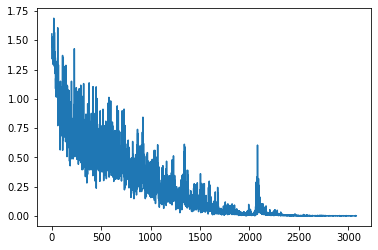

In [6]:
# Traning Process
loss_ls_train = []
model.train()

for epoch in range(Config.epochs):
    for data, labels in train_dl:
        data, labels = data.to(device), labels.to(device)


        optimizer.zero_grad()
        data = data.permute(0, 2, 1)
        data = data.unsqueeze(2)

        prediction = model(data)

        loss = loss_function(prediction, labels)
        loss.backward()
        optimizer.step()

        loss_ls_train.append(loss.data.item())

    print('===> Epoch: {} loss: {:.4f}'.format(epoch, loss.data.item()))

plt.plot(loss_ls_train)
plt.show()


In [7]:
model.eval()
correct_pred = 0
num_pred = 0
map_sum = 0
f1_sum = 0
count = 0


for data, label in test_dl:
    data, label = data.to(device), label.to(device)

    data = data.permute(0, 2, 1)
    data = data.unsqueeze(2)
    softmax_v = F.softmax(model(data), dim=1)
    pred = torch.argmax(softmax_v, dim=1)

    num_pred += len(label)
    correct_pred = correct_pred + torch.eq(pred,label).sum().data.item()

    #tmp_map, _ = computeMeanAveragePrecision(label.detach().cpu().numpy(), softmax_v.detach().cpu().numpy())
    #map_sum += tmp_map
    count +=1

    f1_sum += f1_score(y_true=label.detach().cpu().numpy(), y_pred=pred.detach().cpu().numpy(), average='micro' )

print('Number of correct predictions: ' + str(correct_pred))
print('Number of Predictions:' + str(num_pred))
print('Accuracy: ' + str(correct_pred/num_pred))
print('F1-score: ' + str(f1_sum/count))
print('MAP: ' + str(map_sum/count))

Number of correct predictions: 1502
Number of Predictions:2104
Accuracy: 0.7138783269961977
F1-score: 0.7135416666666666
MAP: 0.0
